In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import matplotlib
import warnings
from gensim import corpora, models
from pprint import pprint
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import NMF
from nltk.tokenize import word_tokenize
import re
import joblib 
import json
import os
import random
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

file_name = {
    'business':'yelp_academic_dataset_business.json',
    'check_in':'yelp_academic_dataset_checkin.json',
    'review':'yelp_academic_dataset_review.json',
    'tip':'yelp_academic_dataset_tip.json',
    'user':'yelp_academic_dataset_user.json'
}

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def remove_special_characters(text):
    # ใช้ regular expression เพื่อลบสัญลักษณะที่ไม่ใช่ตัวอักษร
    cleaned_text = re.sub(r'[^a-zA-Z0-9ก-๙\s]', '', text)
    cleaned_text = re.sub(r'[&\'(),]', '', cleaned_text)
    return cleaned_text

def lemmatize_tokenize(text):#สำหรับทำ lemmatize และ tokenize
    words = remove_special_characters(text)
    words = word_tokenize(words)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if not(word in stop_words)]
    return lemmatized_words
def generate_random_color():
    color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color

In [3]:

business = pd.read_excel('processing_data.xlsx') #อ่านไฟล์ที่ได้จาก build_model.ipynb

bs_id = list(business['business_id'].to_numpy()) 

list_file = [i.split('.')[0] for i in os.listdir("comment")] #ตรวจสอบชื่อไฟล์ที่อยู่ใน folder comment

business_dic ={ bid:business[business['business_id']==bid]['name'].iloc[0] for bid in list_file }

In [4]:
p = list(business_dic.values()).index('District Donuts Sliders Brew') # ชื่อร้านที่จะทดลองทำ Cluster จาก review
comment = pd.read_excel('comment/'+list(business_dic.keys())[p]+'.xlsx')
comment_tf_idf = TfidfVectorizer(
    tokenizer=lemmatize_tokenize
)
text_features = comment_tf_idf.fit_transform(comment['text']).toarray()
tfidf_text_df = pd.DataFrame(columns = comment_tf_idf.get_feature_names_out(),data = text_features) #แปลงเป็น TF-IDF

C:\Users\User01\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


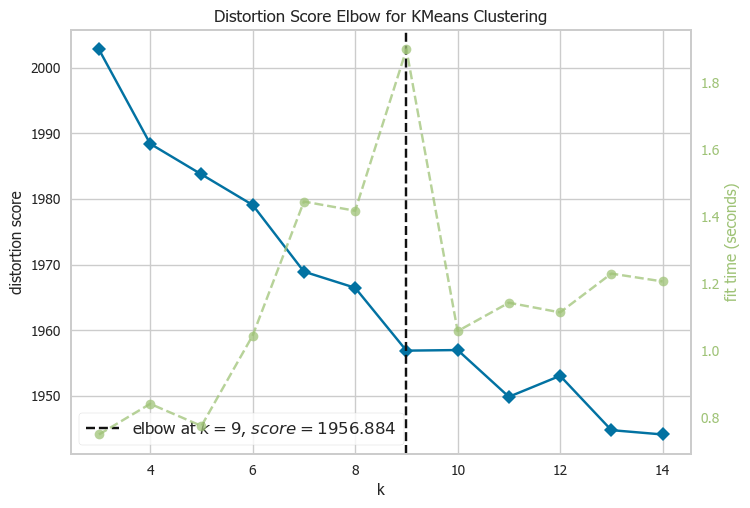

k =  9


<Figure size 800x550 with 0 Axes>

In [50]:
k_cluster = 0
score_cluster = 0
num = 10
al_cluster = ''

# ทำ elbow method
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = KMeans(n_init='auto')
    visualizer = KElbowVisualizer(model, k=(3,15))
    visualizer.fit(tfidf_text_df)        # Fit the data to the visualizer
    if visualizer.elbow_score_ > score_cluster :
        score_cluster = visualizer.elbow_score_
        k_cluster = visualizer.elbow_value_
        al_cluster = al
#             del visualizer
#             del model
    visualizer.show()
    plt.clf()

print("k = ",k_cluster)

In [7]:
kmeans = KMeans(n_clusters=k_cluster,n_init = 'auto',random_state = 42)
tfidf_text_cluster_df = tfidf_text_df.copy()
tfidf_text_cluster_df['Cluster'] = kmeans.fit_predict(tfidf_text_df)
#หา cluster
kmeans.cluster_centers_

array([[ 1.74244599e-03,  1.29876190e-03,  4.06575815e-20, ...,
        -7.45388994e-20,  3.52365706e-19,  1.89735380e-19],
       [-3.93023288e-19, -1.76182853e-19,  2.71050543e-20, ...,
        -8.80914265e-20,  1.35525272e-19,  6.50521303e-19],
       [-3.93023288e-19, -1.76182853e-19,  2.71050543e-20, ...,
        -8.80914265e-20,  1.35525272e-19,  6.50521303e-19],
       ...,
       [-5.14996032e-19, -1.62630326e-19, -2.10064171e-19, ...,
         3.56210904e-04,  4.68817284e-04,  9.48676901e-19],
       [-5.42101086e-19, -2.71050543e-20, -2.57498016e-19, ...,
         6.77626358e-20, -8.67361738e-19,  1.00288701e-18],
       [-6.09863722e-19,  2.98155597e-19, -3.79470760e-19, ...,
         2.16840434e-19, -1.30104261e-18,  1.16551734e-18]])

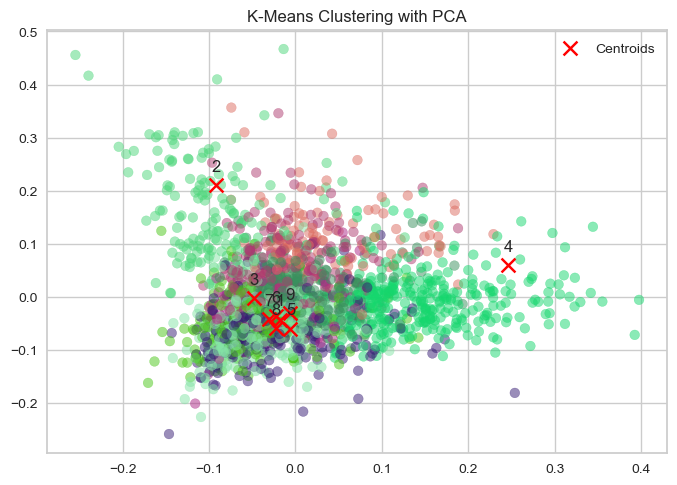

<Figure size 800x550 with 0 Axes>

In [8]:
# ทำ PCA เพื่อให้ข้อมูลเหลือ 2 มิติ
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_text_df)
labels = [str(i) for i in range(1,k_cluster+1)]
colors = {
    i:generate_random_color() for i in range(k_cluster)
}
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=tfidf_text_df.columns)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=tfidf_text_cluster_df['Cluster'].replace(colors), alpha = 0.5)
plt.scatter(pca.fit_transform(kmeans.cluster_centers_)[:, 0], pca.fit_transform(kmeans.cluster_centers_)[:, 1], marker='x', s=100, c='red', label='Centroids')
for i, label in enumerate(labels):
    plt.annotate(label, (pca.fit_transform(kmeans.cluster_centers_)[i, 0], pca.fit_transform(kmeans.cluster_centers_)[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('K-Means Clustering with PCA')
plt.legend()
plt.show()
plt.clf()

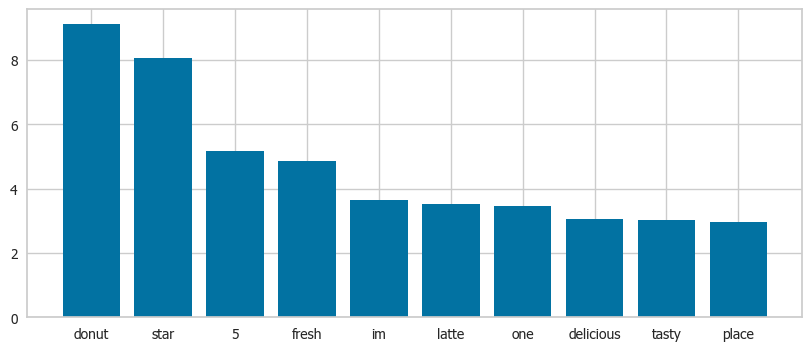

<Figure size 800x550 with 0 Axes>

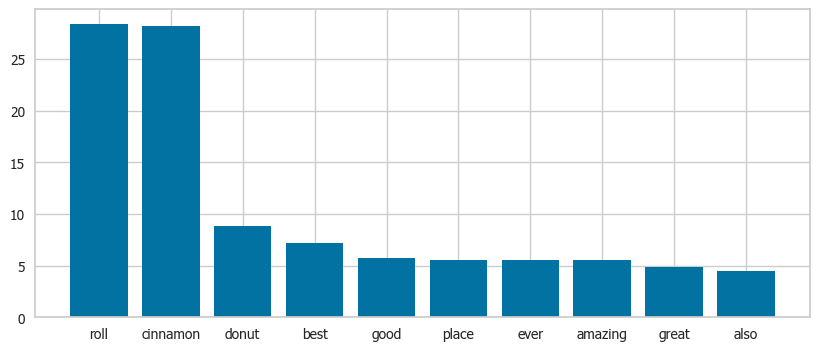

<Figure size 800x550 with 0 Axes>

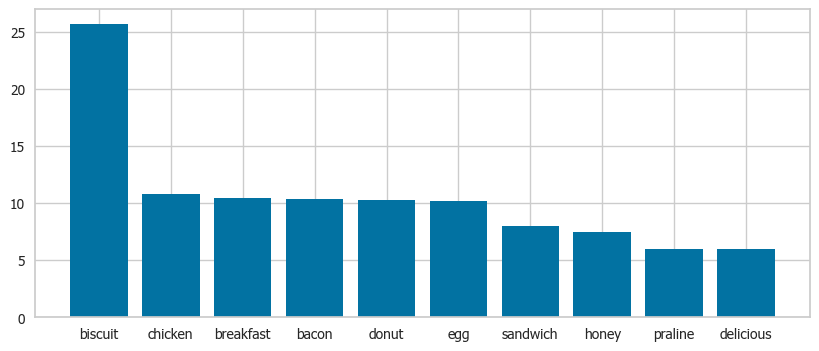

<Figure size 800x550 with 0 Axes>

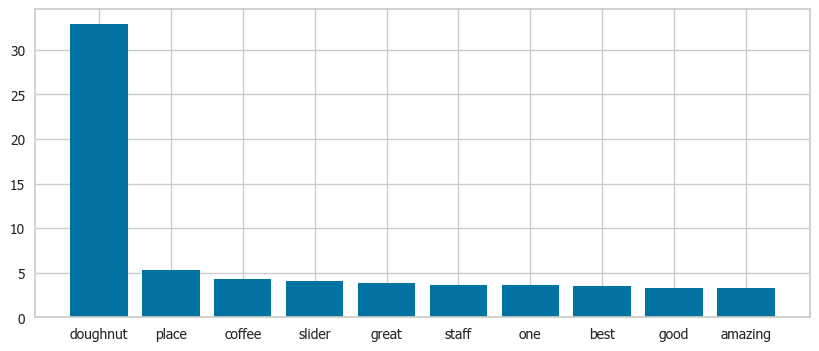

<Figure size 800x550 with 0 Axes>

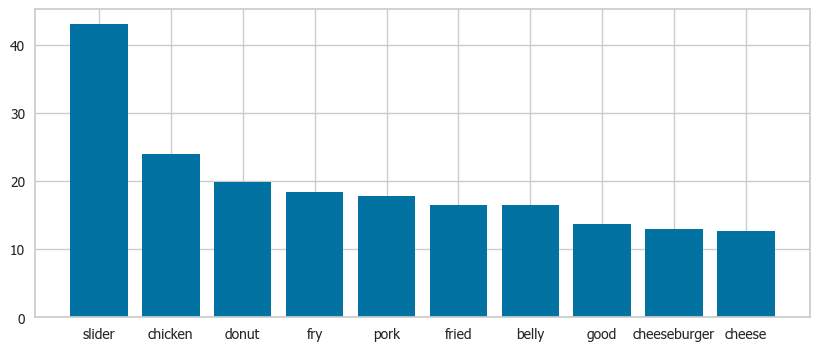

<Figure size 800x550 with 0 Axes>

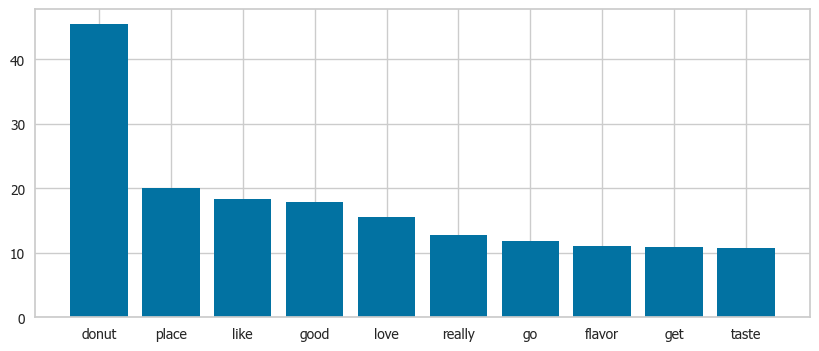

<Figure size 800x550 with 0 Axes>

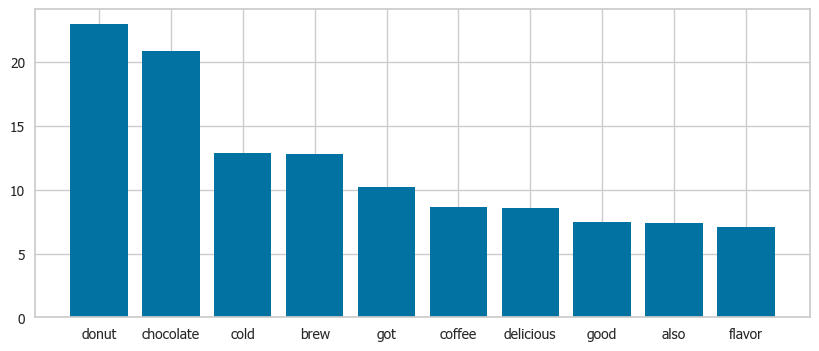

<Figure size 800x550 with 0 Axes>

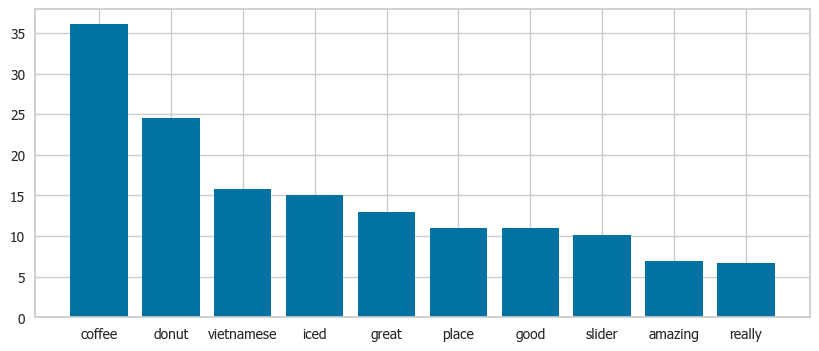

<Figure size 800x550 with 0 Axes>

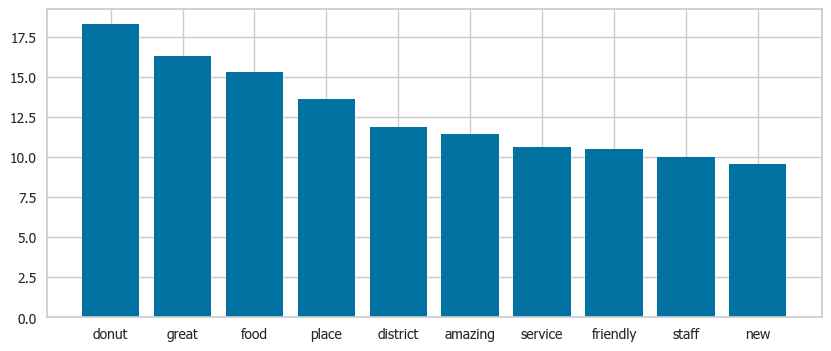

<Figure size 800x550 with 0 Axes>

In [9]:
# แสดงข้อความที่พบบ่อยในแต่ละค  cluster เป็นกราฟแท่ง
result_kmean = []
for group_no in range(0,k_cluster):
        temp = tfidf_text_cluster_df[tfidf_text_cluster_df['Cluster']==group_no].copy()
        temp = temp.drop(['Cluster'],axis=1)
        temp_sum = temp.sum()
        temp = temp.drop(temp_sum[temp_sum == 0].index, axis=1)
        x = temp.sum().sort_values(ascending=False).keys()
        y = temp.sum().sort_values(ascending=False).values
        plt.rcParams['font.family'] = 'tahoma'
        plt.figure(figsize=[10,4]) 
        plt.bar(x[0:10],y[0:10])
        result_kmean.append(list(x[0:10]))
        plt.show()
        plt.clf()

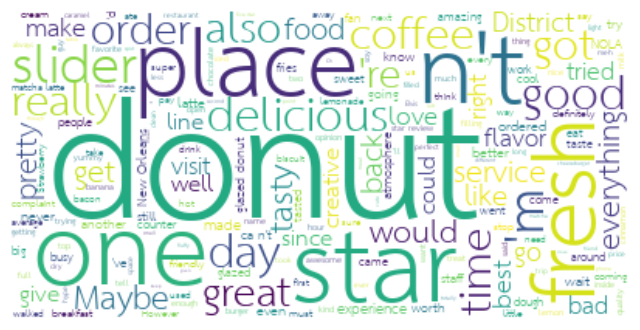

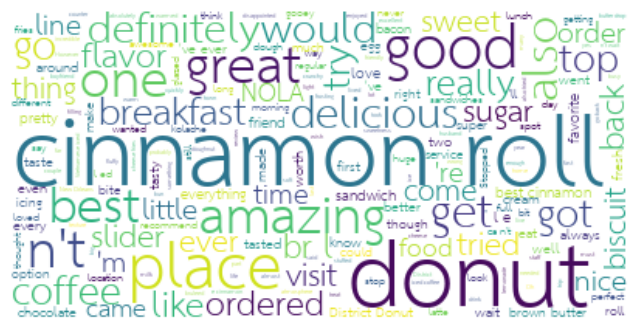

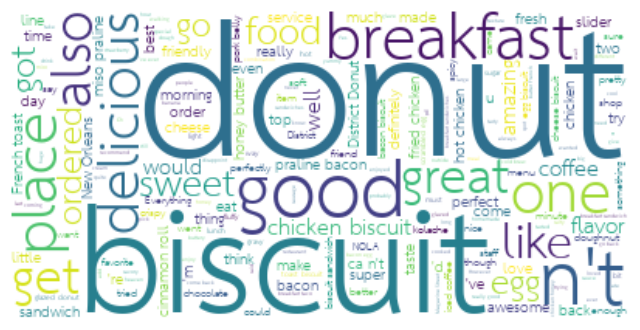

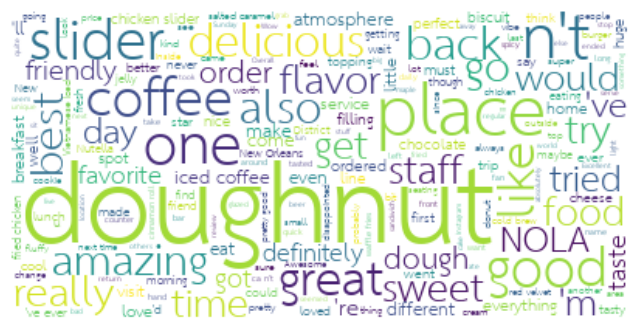

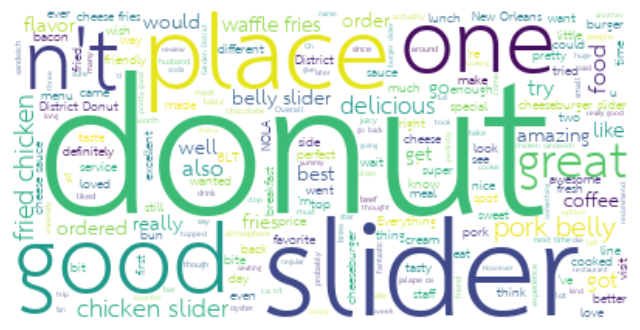

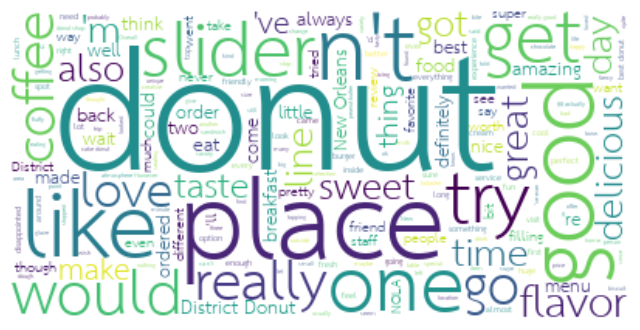

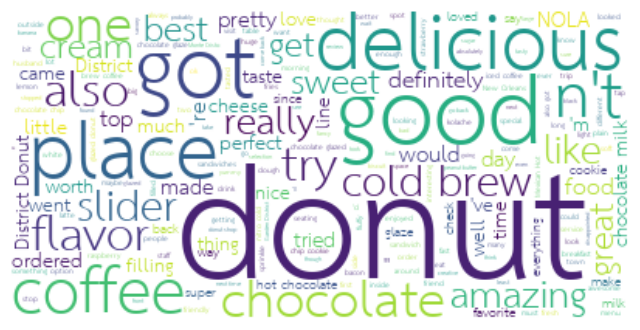

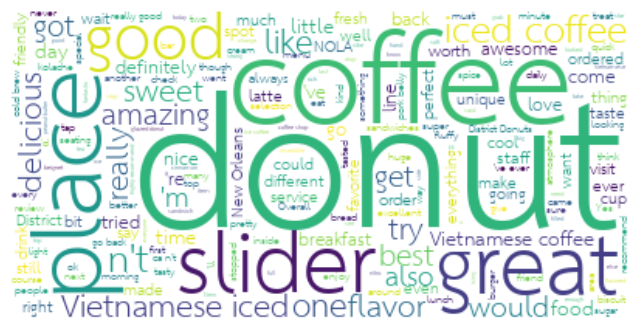

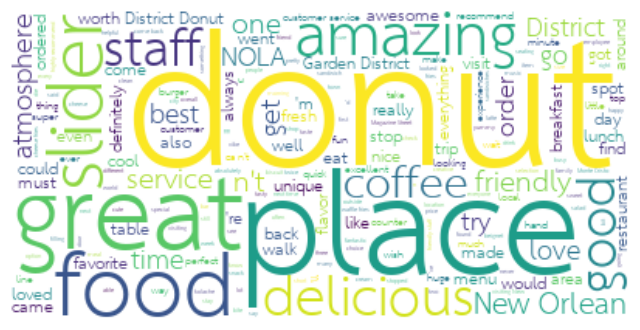

<Figure size 800x550 with 0 Axes>

In [10]:
# แสดงข้อความที่พบบ่อยในแต่ละค  cluster เป็น wordcloud
temp_comment = comment.copy()
temp_comment['Cluster'] = tfidf_text_cluster_df['Cluster'].copy()
for i in range(k_cluster) :
    temp = temp_comment[temp_comment['Cluster']==i].copy()
    text =' '.join([str(i) for i in list(temp['text'].to_numpy()) if i not in stop_words])
    wordcloud = WordCloud(font_path='THSarabunNew.ttf', # path ที่ตั้ง Font
                      stopwords =stop_words, # ลบคำที่ไม่ใช้ออก
                      background_color="white", # ตั้งค่าพืสี้นหลัง
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(word_tokenize(text)))
    plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.clf()

In [12]:
# ทำ NMF
result_nmf = []
nmf_model = NMF(n_components=k_cluster, init='random', random_state=100)

W = nmf_model.fit_transform(tfidf_text_df)
H = nmf_model.components_

# สร้าง DataFrame เพื่อแสดงคำที่เกี่ยวข้องกับแต่ละ topic
feature_names = comment_tf_idf.get_feature_names_out()
df_topics = pd.DataFrame(H, columns=feature_names)

n=10
# แสดงคำที่เกี่ยวข้องกับแต่ละ topic
for i, topic in enumerate(df_topics.values):
    top_keywords_idx = topic.argsort()[:-n-1:-1]  # ดึงคำที่มีค่าสูงสุด 5 คำ
    top_keywords = [feature_names[idx] for idx in top_keywords_idx]
    result_nmf.append(top_keywords)
    print(f"Topic {i+1}: {', '.join(top_keywords)}")
print("==================================================")

Topic 1: biscuit, breakfast, sandwich, bacon, egg, chicken, honey, delicious, praline, miso
Topic 2: slider, chicken, pork, belly, fried, cheeseburger, good, also, beef, got
Topic 3: great, place, food, new, service, amazing, orleans, friendly, staff, atmosphere
Topic 4: coffee, iced, vietnamese, best, donut, latte, ever, ive, great, sweet
Topic 5: fry, cheese, waffle, burger, slider, best, sauce, ever, jalapeos, cheeseburger
Topic 6: donut, like, chocolate, good, flavor, really, one, district, cream, got
Topic 7: doughnut, like, one, ive, staff, blueberry, caramel, best, dough, taste
Topic 8: brew, cold, nitro, try, coffee, beer, ice, delicious, also, good
Topic 9: cinnamon, roll, best, ever, brle, ive, sugar, definitely, amazing, top


C:\Users\User01\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [13]:
# ทำ LDA
documents = list(comment['text'].to_numpy())

# ขั้นตอนที่ 2: สร้าง BoW
texts = [[word.lower() for word in document.split() if not(word.lower() in list(stop_words))] for document in documents]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# ขั้นตอนที่ 3-5: สร้างและทำงานกับโมเดล LDA
lda_model = models.LdaModel(corpus, num_topics=k_cluster, id2word=dictionary, passes=15)
lda_topics = lda_model.print_topics(num_words=10)

# ขั้นตอนที่ 6: ตรวจสอบผลลัพธ์
print(lda_topics)

[(0, '0.015*"donuts" + 0.013*"food" + 0.010*"like" + 0.009*"go" + 0.008*"donut" + 0.008*"slider" + 0.007*"little" + 0.007*"coffee" + 0.007*"great" + 0.006*"would"'), (1, '0.016*"donuts" + 0.015*"donut" + 0.011*"place" + 0.010*"good" + 0.009*"got" + 0.008*"coffee" + 0.007*"definitely" + 0.007*"really" + 0.006*"try" + 0.006*"chicken"'), (2, '0.014*"donut" + 0.013*"-" + 0.011*"like" + 0.010*"donuts" + 0.007*"good" + 0.006*"sweet" + 0.006*"even" + 0.006*"first" + 0.006*"i\'m" + 0.006*"place"'), (3, '0.018*"great" + 0.013*"chicken" + 0.011*"biscuit" + 0.011*"sliders" + 0.010*"also" + 0.010*"pork" + 0.007*"good." + 0.007*"place" + 0.007*"-" + 0.007*"one"'), (4, '0.030*"donut" + 0.024*"donuts" + 0.014*"like" + 0.012*"--" + 0.010*"sliders" + 0.008*"fried" + 0.008*"coffee" + 0.008*"chicken" + 0.008*"flavors" + 0.008*"tried"'), (5, '0.012*"donut" + 0.011*"donuts" + 0.010*"one" + 0.009*"also" + 0.009*"good" + 0.008*"ever" + 0.008*"come" + 0.007*"best" + 0.007*"get" + 0.006*"i\'m"'), (6, '0.030*"d

In [14]:
# นำผลลัพธ์จาก LDA มาทำให้เหลือแค่คำ
result_lda = []
for topic in lda_topics :
    result_lda.append(re.findall(r'[a-zA-Z]+', topic[1]))

In [16]:
# แสดงผลลัพธ์ของแต่ละวิธี
print("Kmean")
for i in range(k_cluster) :
    print(i,':',result_kmean[i])
print("NMF")
for i in range(k_cluster) :
    print(i,':',result_nmf[i])
print("LDA")
for i in range(k_cluster) :
    print(i,':',result_lda[i])

Kmean
0 : ['donut', 'star', '5', 'fresh', 'im', 'latte', 'one', 'delicious', 'tasty', 'place']
1 : ['roll', 'cinnamon', 'donut', 'best', 'good', 'place', 'ever', 'amazing', 'great', 'also']
2 : ['biscuit', 'chicken', 'breakfast', 'bacon', 'donut', 'egg', 'sandwich', 'honey', 'praline', 'delicious']
3 : ['doughnut', 'place', 'coffee', 'slider', 'great', 'staff', 'one', 'best', 'good', 'amazing']
4 : ['slider', 'chicken', 'donut', 'fry', 'pork', 'fried', 'belly', 'good', 'cheeseburger', 'cheese']
5 : ['donut', 'place', 'like', 'good', 'love', 'really', 'go', 'flavor', 'get', 'taste']
6 : ['donut', 'chocolate', 'cold', 'brew', 'got', 'coffee', 'delicious', 'good', 'also', 'flavor']
7 : ['coffee', 'donut', 'vietnamese', 'iced', 'great', 'place', 'good', 'slider', 'amazing', 'really']
8 : ['donut', 'great', 'food', 'place', 'district', 'amazing', 'service', 'friendly', 'staff', 'new']
NMF
0 : ['biscuit', 'breakfast', 'sandwich', 'bacon', 'egg', 'chicken', 'honey', 'delicious', 'praline', 'm

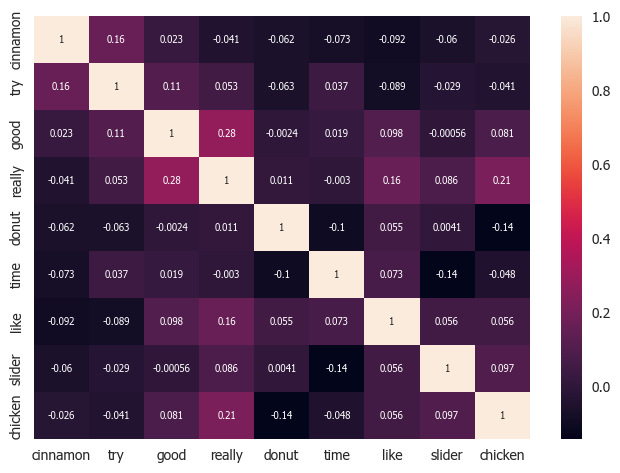

<Figure size 800x550 with 0 Axes>

In [131]:
# แสดงคำที่พบด้วยยกันบ่อย
group_no = 7
temp = tfidf_text_cluster_df[tfidf_text_cluster_df['Cluster']==group_no].copy()
columns = ' '.join(result_lda[group_no])
temp = temp[list(set(lemmatize_tokenize(columns)))]
temp
sns.heatmap(temp.corr(),annot=True ,annot_kws={"size": 7})
plt.show()
plt.clf()

# ด้านล่างสำหรับจัดการกับไฟล์ yelp_academic_dataset_review.json เนื่องจากไฟล์มีขนาดใหญ่จึงจะแบ่งจัดการทีละส่วน

In [ ]:
# chunk_size = 10**6  # อาจต้องปรับขนาดตามความเหมาะสม
# json_path = 'dataset'+'/'+file_name['review']
# bs_id = list(business['business_id'].to_numpy())

# chunk_size = 10**6  # อาจต้องปรับขนาดตามความเหมาะสม
# # อ่านไฟล์ JSON แบบ Streaming
# json_reader = pd.read_json(json_path, lines=True, chunksize=chunk_size)

# for j in range(9,len(bs_id)) :
#     temp_id = bs_id[j]
#     if temp_id in list_file :
#         continue
#     temp = ''
#     json_reader = pd.read_json(json_path, lines=True, chunksize=chunk_size)
#     for chunk in json_reader:
#     # ทำสิ่งที่คุณต้องการกับ chunk นี้
        
#         temp = chunk[chunk['business_id']==temp_id][['business_id','stars','text']]
#         if len(temp) != 0 :
#             temp.to_excel('comment/'+bs_id[j]+'.xlsx',index=False)